# Automatic Identification of Natural Disasters from Satellite Images

Local, States, National or even foreign governments need support as to implement short-term emergency response, and long-term hazard mitigation measures at the occurrences of natural disaster such as tropical cyclones, wildfires, earthquakes, etc. The sample notebook takes advantage of [NASA's Earth Observatory Natural Event Tracker (EONET) API](https://eonet.sci.gsfc.nasa.gov/eonet-project) to collect a curated source of continuously updated natural event metadata, then creates [FeatureCollection(s)](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurecollection) based on the descriptions and geo-information provided in the metadata feed for each type of the natural disasters, and saves into a Web Map item on the targeted GIS connection. 

In the meantime, with the temporal and geospatial information of the event occurrence, this sample goes on to query the before- and after- disaster satellite images of the prone areas, and add as overlay layers besides the FeatureCollection generated at the first step. The differences between the two temporal conditions can be collected for training dataset, and hence when there are sufficient of these images (or labels), we can build a model to identify from the satellite images if there is a natural disaster (e.g. tropical cyclone).

With the sample notebook run in a scheduled routine, there will be a latest web map that contains the up-to-date list of natural  disaster occurrences in your organization always. For example, the eruption of Karymsky Volcano in Russia on Feb 15th, 2019 appears as one of the recent events in the `EONET API Feed`, and it would be represented in three forms - as an event vector, a pre-disaster satellite imagery, and a post-disaster satellite image.

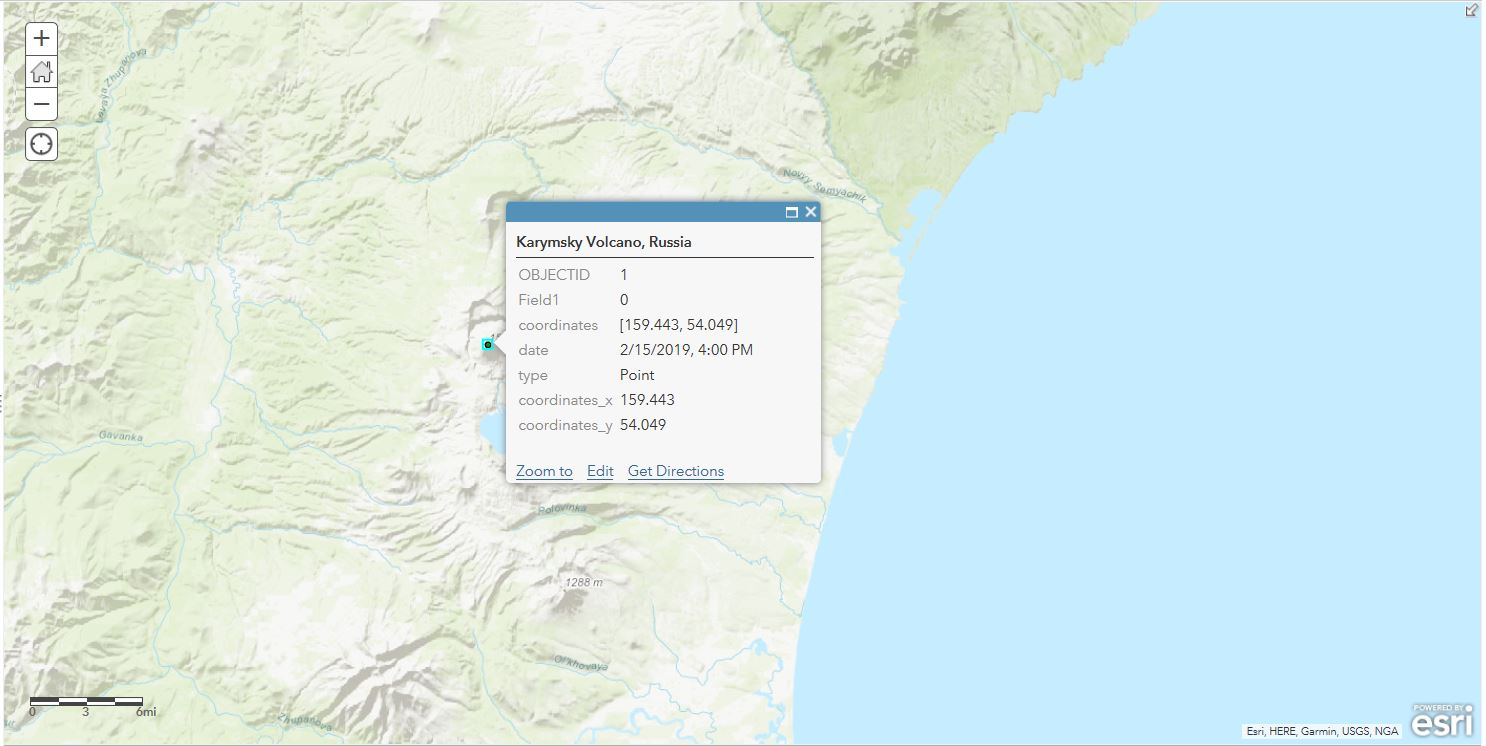

In [11]:
from IPython.display import Image
from pathlib import Path
filename = Path('staticimg/automatic-identification-of-natural-disasters/Russia_Volcano_vector.jpg')
if filename.exists():
    display(Image(filename = str(filename), height = 300, width =900))

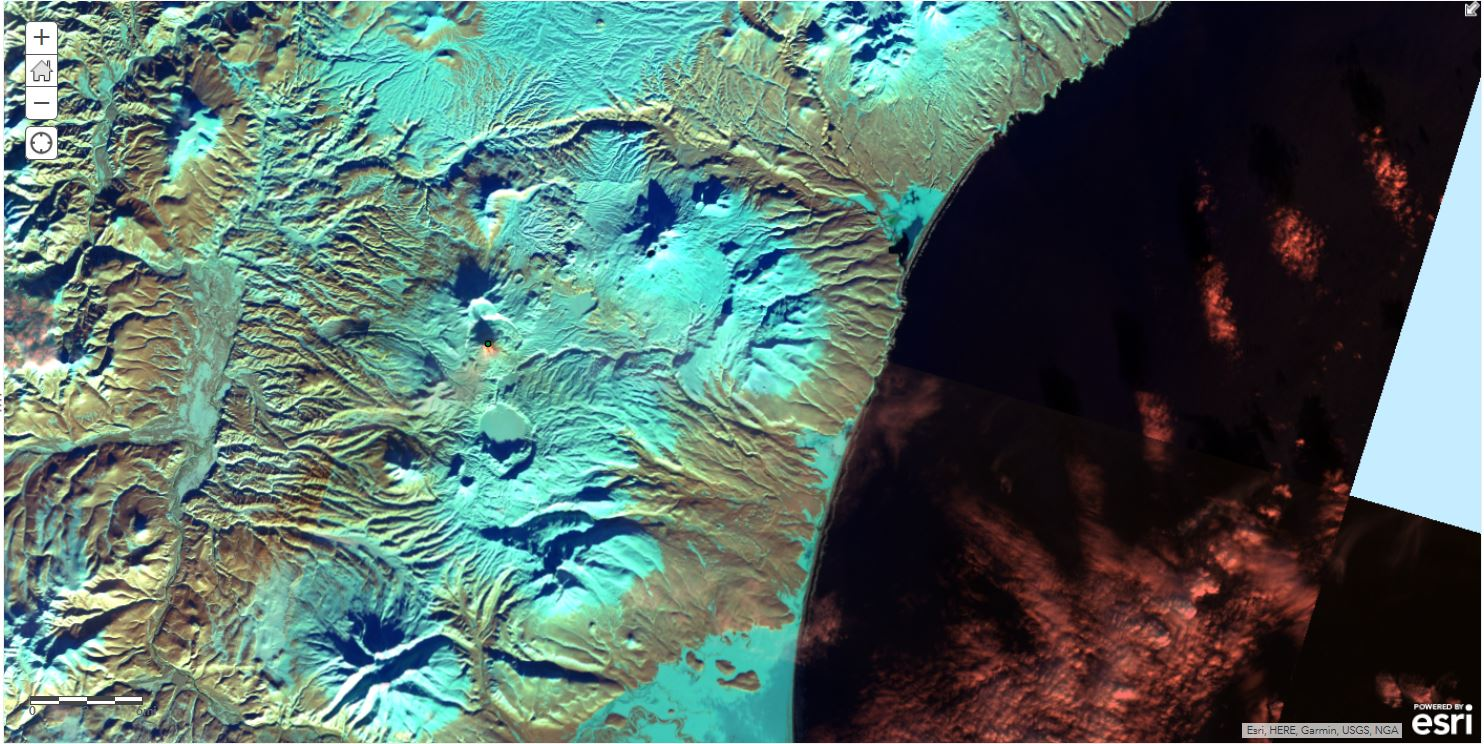

In [12]:
filename = Path('staticimg/automatic-identification-of-natural-disasters/Russia_Volcano_raster_before.jpg')
if filename.exists():
    display(Image(filename = str(filename), height = 300, width =900))

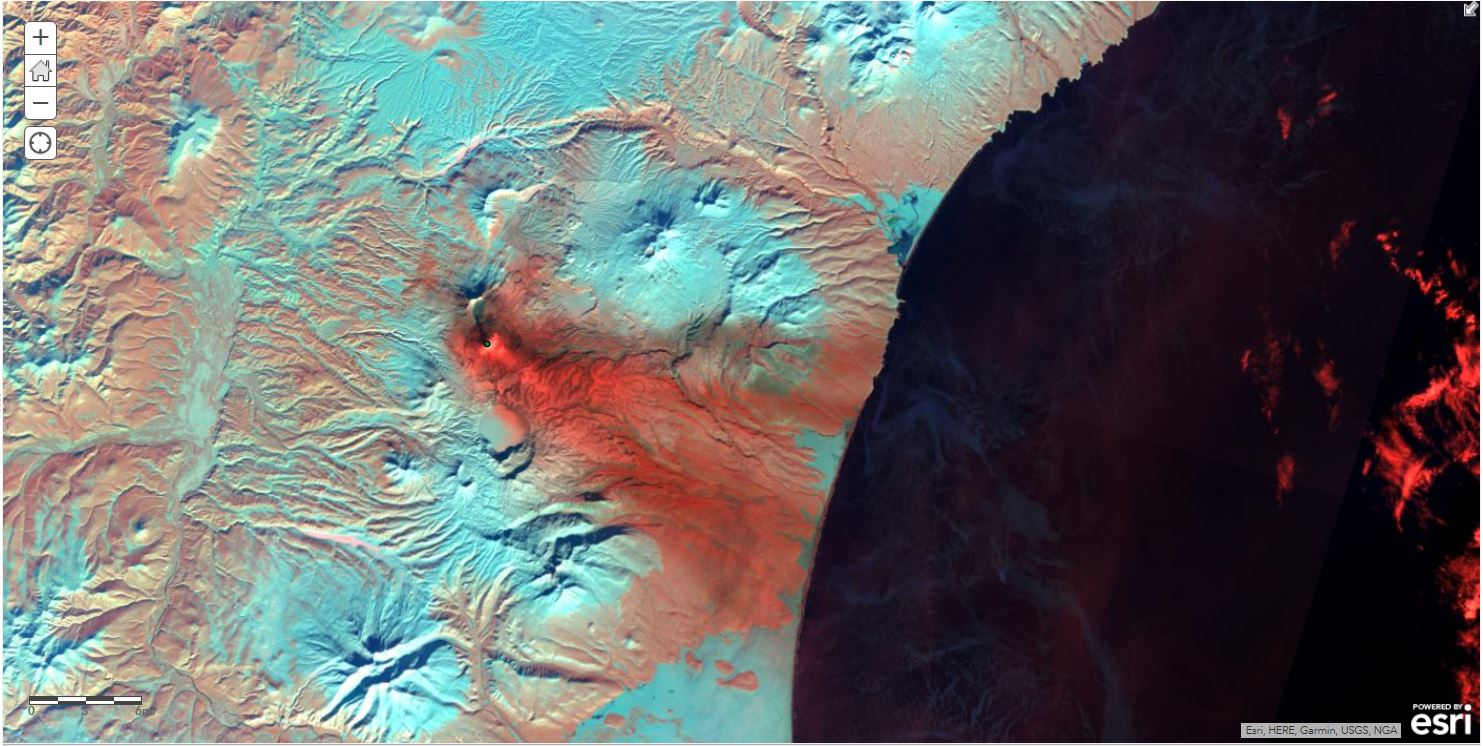

In [13]:
filename = Path('staticimg/automatic-identification-of-natural-disasters/Russia_Volcano_raster_after.jpg')
if filename.exists():
    display(Image(filename = str(filename), height = 300, width =900))

## Step 1. Preparation
In order to access the Land Remote-Sensing Satellite (System) (in short, Landsat) dataset, the first step is to connect to ArcGIS Online organization since `esri livingatlas` provided a series of good-to-use Landsat products in forms of imagery layers ready for query, visualization and analysis. You can do so via existing online profile, or just enter username/password as in `gis = GIS('https://www.arcgis.com',"arcgis_python","P@ssword123")`. 

Then to create another GIS class object for an ArcGIS Enterprise deployment in case that you want to save the target web map in a different destination than ArcGIS Online. Same here, the GIS connection can be created via profile, or using u/p (`portal_gis = GIS('https://pythonapi.playground.esri.com/portal','arcgis_python','amazing_arcgis_123')`).

In [1]:
from arcgis.gis import GIS

gis = GIS(profile = 'your_online_profile')
portal_gis = GIS(profile = 'your_enterprise_profile')

The `exact_search` method here is to start a search based on title, owner and item type, then use a for loop to traverse all the query results in order to get an exact match that has the desired title and item type. It can be used in place of the generic `search` method so you do not need to specify the index of the desired imagery layery among all the search results. As seen here, the output of the `exact search` is a Imagery Layer item titled `"Multispectral Landsat"`.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
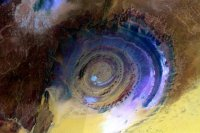

In [2]:
def exact_search(my_gis, title, owner_value, item_type_value):
    final_match = None
    search_result = my_gis.content.search(query= title + ' AND owner:' + owner_value, item_type=item_type_value, outside_org=True)
    
    if "Imagery Layer" in item_type_value:
        item_type_value = item_type_value.replace("Imagery Layer", "Image Service")
    elif "Layer" in item_type_value:
        item_type_value = item_type_value.replace("Layer", "Service")
    
    for result in search_result:
        if result.title == title:
            final_match = result
            break
    return final_match

landsat_item = exact_search(gis, 'Multispectral Landsat', 'esri', 'Imagery Layer')
landsat = landsat_item.layers[0]
landsat_item

The Python API also supports specifying Javascript renderers via `autocasting`. This Python API displays maps in a Jupyter notebook by leveraging the ArcGIS API for JavaScript. By specifying `"renderer": "autocast"` for any renderer, you are directing Python to allow the Javascript API to attempt to infer the renderer by following Javascript API rules. Besides using `add_layer(...)` method to add the newly created feature class or feature service into map view (using renderer JSON in the parameter), you can also use `draw(...)` method with symbol and pop-up specified in the arguments list. 

Renderer or Symbol JSON for different natural disasters are defined here as entries for dictionary objects (e.g. `symbol_doct` or `renderer_dict`).

Sample symbol JSONs can be generated from [Symbol Marker](http://esri.github.io/arcgis-python-api/tools/symbol).

In [3]:
# Symbol of Tropical Cyclone
symbol_storm = {"angle":0,"xoffset":0,"yoffset":0,
                "type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/OutdoorRecreation/Lightning.png",
                "contentType":"image/png",
                "width":24,"height":24
               }
renderer_storm = {"renderer": "autocast",
                  "type":"simple",
                  "symbol": symbol_storm
                 }

# Symbol of Wildfires
symbol_wildfire = { "angle":0,"xoffset":0,"yoffset":0,
                    "type":"esriPMS",
                    "url":"https://static.arcgis.com/images/Symbols/NPS/Campfire_1.png",
                    "contentType":"image/png",
                    "width":24,"height":24
                   }
renderer_wildfire = {"renderer": "autocast",
                     "type": "simple",
                     "symbol": symbol_wildfire
                    }

# Symbol of volcano eruption
symbol_volcano = { "angle":0,"xoffset":0,"yoffset":0,
                   "type":"esriPMS",
                   "url":"https://static.arcgis.com/images/Symbols/NPS/Grill.png",
                   "contentType":"image/png",
                   "width":24,"height":24
                  }
renderer_volcano = {"renderer": "autocast",
                    "type": "simple",
                    "symbol": symbol_volcano
                    }

# Symbol of Iceberg
symbol_iceberg = {"angle":0,"xoffset":0,"yoffset":0,
                  "type":"esriPMS",
                  "url":"https://static.arcgis.com/images/Symbols/NPS/Ice_1.png",
                  "contentType":"image/png",
                  "width":24,"height":24
                 }
renderer_iceberg = {"renderer": "autocast",
                    "type": "simple",
                    "symbol": symbol_iceberg
                    }

# dictionary objects
symbol_dict = {
    "Tropical Cyclone": symbol_storm,
    "Wildfires": symbol_wildfire,
    "Volcano": symbol_volcano,
    "Iceberg": symbol_iceberg
}
renderer_dict = {
    "Tropical Cyclone": renderer_storm,
    "Wildfires": renderer_wildfire,
    "Volcano": renderer_volcano,
    "Iceberg": renderer_iceberg
}

## Step 2. Understanding the data structure of Feed

Carefully studying the geodata feed at [https://eonet.sci.gsfc.nasa.gov/api/v2.1/events](https://eonet.sci.gsfc.nasa.gov/api/v2.1/events), we come to the conclusion that the collector of events have listed the geospatial info in two ways - a list of single geometry, or a list of multiple geometries. Also, the method to parse these geometries in order to retrieve the `[coordinates_x, coordinates_y]` pair(s) is slightly different.

**First**, when there is only a single geometry in the list -

In [4]:
import requests
import json
import pandas as pd

response = requests.get("https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_980")  
json_event = json.loads(response.text)
print(json_event["title"])
print(json_event["geometries"])

Fuego Volcano, Guatemala
[{'date': '2002-01-04T00:00:00Z', 'type': 'Point', 'coordinates': [-90.88, 14.473]}]


In [5]:
r = json.dumps(json_event["geometries"])
df = pd.read_json(r, orient=",")
df

,coordinates,date,type
0,"[-90.88, 14.473]",2002-01-04,Point


In [6]:
df[['coordinates_x', 'coordinates_y']] = pd.DataFrame(df['coordinates'].values.tolist(), index=df.index)
df

,coordinates,date,type,coordinates_x,coordinates_y
0,"[-90.88, 14.473]",2002-01-04,Point,-90.88,14.473


In [7]:
df.coordinates.tolist()[0]

[-90.88, 14.473]

With the `[date, coordinates_x, coordinates_y]` returned from above, we can then go on to generate FeatureCollection(s) on the target GIS via `import_data`. This is relatively easier than parsing the geo-information in the second situation, in which we are getting more than one geo-information entry, and need to split the list of geometries in a single column into multiple rows (that is implemented via `splitDataFrameList` method). Check the cells below for detailed steps.

In [8]:
response = requests.get("https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_354")
json_event = json.loads(response.text)
print(json_event["title"])
print(json_event["geometries"])

Dukono Volcano, Indonesia
[{'date': '2016-03-16T00:00:00Z', 'type': 'Polygon', 'coordinates': [[[127.84286499023438, 1.6633016286241373], [127.84286499023438, 1.7379700300000804], [127.91641235351562, 1.7379700300000804], [127.91641235351562, 1.6633016286241373], [127.84286499023438, 1.6633016286241373]]]}]


In [9]:
r = json.dumps(json_event["geometries"])
df = pd.read_json(r, orient=",")
df

,coordinates,date,type
0,"[[[127.84286499023438, 1.6633016286241369], [1...",2016-03-16,Polygon


In [10]:
df.coordinates.tolist()[0][0]

[[127.84286499023438, 1.6633016286241369],
 [127.84286499023438, 1.73797003000008],
 [127.91641235351562, 1.73797003000008],
 [127.91641235351562, 1.6633016286241369],
 [127.84286499023438, 1.6633016286241369]]

Because what we have got from above is a list of co-ordinates, using a list of geometries mapping to a single feature type would result in `ValueError: Columns must be same length as key`, we need to go through an extra step to split the list into multiple rows.

In [11]:
def splitDataFrameList(df,target_column):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def splitListToRows(row):
        for s in row[target_column][0]:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)

    df.apply(splitListToRows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
    return new_df

In [12]:
df = splitDataFrameList(df, "coordinates")
df

,coordinates,date,type
0,"[127.84286499023438, 1.6633016286241369]",2016-03-16,Polygon
1,"[127.84286499023438, 1.73797003000008]",2016-03-16,Polygon
2,"[127.91641235351562, 1.73797003000008]",2016-03-16,Polygon
3,"[127.91641235351562, 1.6633016286241369]",2016-03-16,Polygon
4,"[127.84286499023438, 1.6633016286241369]",2016-03-16,Polygon


In [13]:
df.coordinates.tolist()[0]

[127.84286499023438, 1.6633016286241369]

In order to read the geometries from JSON, and also to differentiate between the two situations (having one geolocation, and a list of multiple geolocations), the `geometries_to_fc` and `prepare_dataframeFor_publishing` handle them both.

In [14]:
def prepare_dataframeFor_publishing(df):
    """if in situations when you have a list of coordinates
    """
    if len(df['coordinates'].tolist()[0]) == 1 and isinstance(df['coordinates'].tolist()[0][0], list):
        df = splitDataFrameList(df, "coordinates")
    
    """split coordinates into ['coordinates_x', 'coordinates_y']
    """
    df[['coordinates_x', 'coordinates_y']] = pd.DataFrame(df['coordinates'].values.tolist(), index=df.index)
    
    return df

def geometries_to_fc(geoms):
    r = json.dumps(geoms)
    df = pd.read_json(r, orient=",")
    df = prepare_dataframeFor_publishing(df)
    fc = portal_gis.content.import_data(df, location_type="coordinates",
                                            longitude_field="coordinates_x",
                                            latitude_field="coordinates_y")
    return fc

## Step 3. Creating the web map
The sample would require three user-defined functions to: a. parse the metadata feed (in GeoJSON) and create one FeatureClass per event, and add the FeatureClass to a map, b. obtain the temporal range and the spatial boundingbox of the FeatureClass, perform `filter_by(...)` to the landsat imagery layer with the criteria, and add the before- and after- disaster imageries to the map, and c. store the current map as web map.

In the `filter_images` method defined below, given the temporal range and the spatial boundingbox of the FeatureClass, `filter_by(...)` is performed to the landsat imagery layer with the criteria, and when one or more mosiac tiles meet the requirements, get the `mean` of these tiles and add to current map.

In [15]:
import arcgis
from arcgis import geometry
from arcgis.geometry import Geometry
import datetime as dt

def filter_images(fc, my_map, start_datetime, end_datetime):
    
    geom_obj = Geometry(fc.properties.layerDefinition.extent)
    selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.2)",
                                 time=[start_datetime, end_datetime],
                                 geometry=geometry.filters.intersects(geom_obj))
    # print("Applicable lockRasterIds=", selected._mosaic_rule.get("lockRasterIds"))
    
    if not selected._mosaic_rule.get("lockRasterIds"):
        return None
    else:
        date_title_from = start_datetime.strftime("%m/%d/%Y")
        date_title_to = end_datetime.strftime("%m/%d/%Y")
        extents = fc.properties.layerDefinition.extent
        extents_str = ",".join(format(x, "10.3f") for x in [extents['xmin'],extents['ymin'],extents['xmax'], extents['ymax']])

        my_map.add_layer(selected.mean(), {"title": date_title_from + " to " + date_title_to + " at [" + extents_str + "]"})

        fs = selected.query(out_fields="AcquisitionDate, GroupName, Month, DayOfYear, WRS_Row, WRS_Path")
        tdf = fs.sdf  
        # print(tdf.shape)
        return tdf

Next, the `create_all_fs_from_json` method sends a request to the API's feed URL, reads the response into json object, and then has all events in the feed json traversed to check for the disaster type, geolocation and descriptions of each event. These information will be used to create a FeatureClass for each event in `portal_gis` which can be then added to the current map. When the `save_to_fc` boolean is True, the function will then save each feature class into an individual FeatureCollection item on the enterprise; when the `add_Landsat` boolean is True, the function will automatically invoke `filter_images` to get the before- and after- disaster satellite images to the map.

In [16]:
import traceback
from arcgis.features import Feature, FeatureSet

fclist = []
fclist_r = []

def create_all_fs_from_json(url, disaster_type, add_to_map=None, 
                            use_default_symbol = True, save_to_fc = False, add_Landsat = False):
    response = requests.get(url)
    json_data = json.loads(response.text)
    item_list = []

    for event in json_data["events"]:
        if disaster_type in event["title"]:           
            try:
                # print(event["title"], event["link"])
                resp_event = requests.get(event["link"])
                json_event = json.loads(resp_event.text)
                
                """parse geometries in the json, and publsih into feature collection
                """
                fc = geometries_to_fc(json_event["geometries"])
                fclist.append(fc)
                
                if add_to_map is not None:
                    if use_default_symbol:
                        """ Add_layer() used directly
                        """
                        add_to_map.add_layer(fc, {"title": event["title"]})
                    else:
                        """ draw(...) to add sketch item to map
                        """
                        f_list = []
                        for feature in fc.properties.featureSet.features:
                            f1 = Feature(geometry={'x': feature.geometry["x"],
                                                   'y': feature.geometry["y"]})
                            f_list.append(f1)
                        fset = FeatureSet(f_list, geometry_type='esriGeometryPoint', 
                                          spatial_reference={'latestWkid': 3857})
                        add_to_map.draw(fset, symbol=symbol_dict[disaster_type], attributes={"title": event["title"]})
                    # print("... FC Added")
                
                if save_to_fc:
                    item_properties = {
                        "title": json_event["title"],
                        "tags" : disaster_type,
                        "snippet": json_event["categories"][0]['title'],
                        "description": json_event["sources"][0]['url'],
                        "text": json.dumps({"featureCollection": {"layers": [dict(fc.layer)]}}),
                        "type": "Feature Collection",
                        "typeKeywords": "Data, Feature Collection, Singlelayer"
                    }
                    item = portal_gis.content.add(item_properties)
                    item_list.append(item.itemid)
                
                if (add_to_map is not None) and add_Landsat:
                    datetime_object = dt.datetime.strptime(json_event["geometries"][0]['date'], '%Y-%m-%dT%H:%M:%SZ')
                    start_datetime = datetime_object - dt.timedelta(days=63)
                    end_datetime = datetime_object - dt.timedelta(days=21)
                    tdf1 = filter_images(fc, add_to_map, start_datetime, end_datetime)
                    if tdf1 is not None:
                        tdf1.head()
                    
                    start_datetime = datetime_object - dt.timedelta(days=21)
                    end_datetime = datetime_object + dt.timedelta(days=21)
                    tdf2 = filter_images(fc, add_to_map, start_datetime, end_datetime)
                    if tdf2 is not None:
                        tdf2.head()
                        if tdf1 is not None:
                            fclist_r.append(fc)

            except Exception:
                print(traceback.format_exc())
                print(event["title"], event["link"], "... Skipped")
    return item_list

And `create_wm_from_list(...)` can be used to create a web map from a list of FeatureCollection items.

In [17]:
from arcgis.mapping import WebMap

def create_wm_from_list(fc_list, disaster_type, wm_item = None):
    if wm_item is None:
        wm = WebMap()
    else:
        wm = WebMap(wm_item)

    for fc in fc_list:
        new_item= portal_gis.content.search(fc)[0]
        wm.add_layer(new_item, options={'title':disaster_type})

    web_map_properties = {'title':disaster_type + " WM",
                         'snippet':'This web map contains multiple '+ disaster_type + ' FS',
                         'tags':'ArcGIS Python API'}

    # Call the save() with web map item's properties.
    web_map_item = wm.save(item_properties=web_map_properties)
    return web_map_item

For example, a simple usage of `create_all_fs_from_json` is shown below to create a web map containing recent tropical cyclones as FeatureCollection objects.

In [18]:
map2 = gis.map('USA')

disaster_type = "Tropical Cyclone" # disaster_type picked from "Tropical Cyclone", "Wildfires", "Volcano", "Iceberg"
save_to_fc = False # set to True, if you want to save each FeatureCollection into a Feature Layer

fc_item_list = create_all_fs_from_json("https://eonet.sci.gsfc.nasa.gov/api/v2.1/events", disaster_type, map2, False, save_to_fc)

web_map_properties = {'title': "Natural Disasters (" + disaster_type + ") Collection",
                      'snippet':'This web map contains multiple '+ disaster_type + ' FC',
                      'tags':'ArcGIS Python API'}

if save_to_fc:
    create_wm_from_list(fc_item_list, disaster_type)
else:
    map2.save(item_properties=web_map_properties)

In [19]:
wm_item = exact_search(portal_gis, 'Natural Disasters (' + disaster_type + ') Collection', '*', 'Web Map')
wm_item

<Item title:"Natural Disasters (Tropical Cyclone) Collection" type:Web Map owner:arcgis_python>

In [20]:
# Number of FeatureCollection in this web map
len(fclist)

1


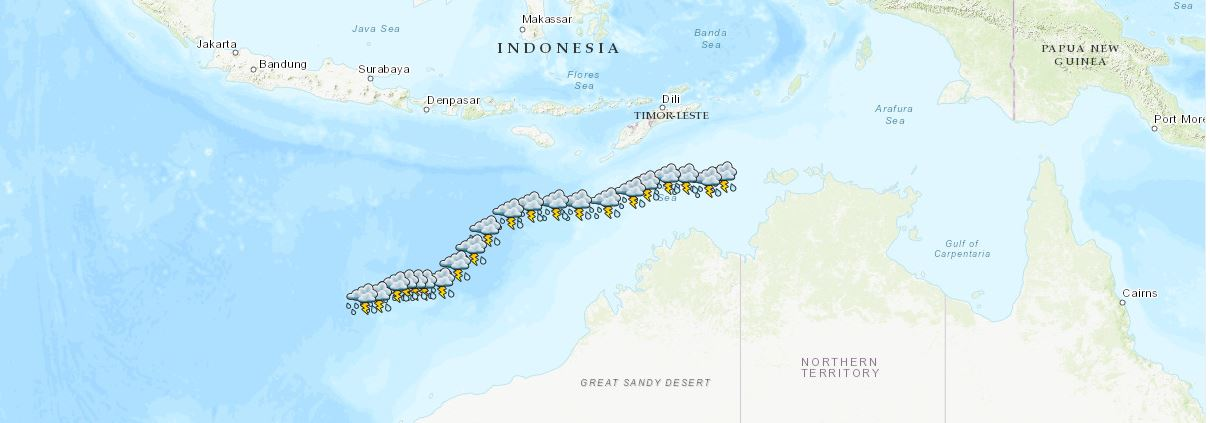

In [3]:
# zoom to "Tropical Cyclone Wallace"
map2.zoom = 12
map2.center= [-12.9, 119.7]
map2

A more advanced usage is to create the web map that includes recent events for a list of natural disaster types as FeatureCollection objects, and also attach the before- and after-disaster satellite images in the web map.

In [18]:
# disaster_type picked from "Tropical Cyclone", "Wildfires", "Volcano", "Iceberg"
disasters = ["Tropical Cyclone", "Wildfires", "Volcano"] 
map3 = gis.map('USA')

for disaster_type in disasters:
    fc_item_list = create_all_fs_from_json("https://eonet.sci.gsfc.nasa.gov/api/v2.1/events", 
                                           disaster_type, map3, add_Landsat = True)

if len(disasters) > 1:
    wm_token = ", ".join(str(e) for e in disasters)
else:
    wm_token = disasters[0]
    
web_map_properties = {'title': "Natural Disasters (" + wm_token + ") Collection",
                      'snippet':'This web map contains multiple '+ disaster_type + ' FC',
                      'tags':'ArcGIS Python API'}

# Call the save() with web map item's properties.
map3.save(item_properties=web_map_properties)

<Item title:"Natural Disasters (Tropical Cyclone, Wildfires, Volcano) Collection" type:Web Map owner:arcgis_python>

The limitations in the spatial and temporal coverage of lansat dataset, not all of the feature collections created from the natual disaster feed is accompanied with its satellite image validations, and the percentage of feature collection having both before- and post- disaster images is shown as:

In [19]:
print(len(fclist_r), " out of ", len(fclist))

31  out of  57


## Step 4. Explore the data and the maps

You can either access the web map item from opening the link, or simply drawing the map in the current map view.

Use `visit_features_on_map_widget` method to explore the places automatically -

In [20]:
"""# Helper functions to change the extent of a web map 
   # based on point's location, or envelope's bbox
"""
import time
from arcgis.geometry import project

def return_center_or_extent(fc):
    features = fc.properties.featureSet.features
    if len(features) == 0:
        return None
    elif len(features) == 1:
        geom = features[0].geometry
    else:
        geom = fc.properties.layerDefinition.extent
    if 'spatialReference' in geom:
        del geom['spatialReference']
    return geom

def return_projected_center(geom):
    return project([geom], in_sr=3857, out_sr=4326) 
    
def visit_sites(m, sites, timesleep, zoom_level=15):
    m.zoom = zoom_level
    for site in sites:
        if 'xmin' in site[0]:
            tmp = [[site[0]['xmin'], site[0]['ymin']], [site[0]['xmax'], site[0]['ymax']]]
            m.extent = tmp
            print("extent: ", tmp)
        else:
            tmp = [float(site[0]['y']), float(site[0]['x'])]
            m.center = tmp
            print("center: ", tmp)

        time.sleep(timesleep)
        
def visit_features_on_map_widget(map_obj, fclist_sel, zoom_level=15,  
                                 timesleep=5):
    sitelist = list(map(lambda x: return_center_or_extent(x), fclist_sel))
    proj_sitelist = list(map(lambda x: return_projected_center(x), sitelist))
    visit_sites(map_obj, proj_sitelist, timesleep)

MapView(layout=Layout(height='400px', width='100%'))


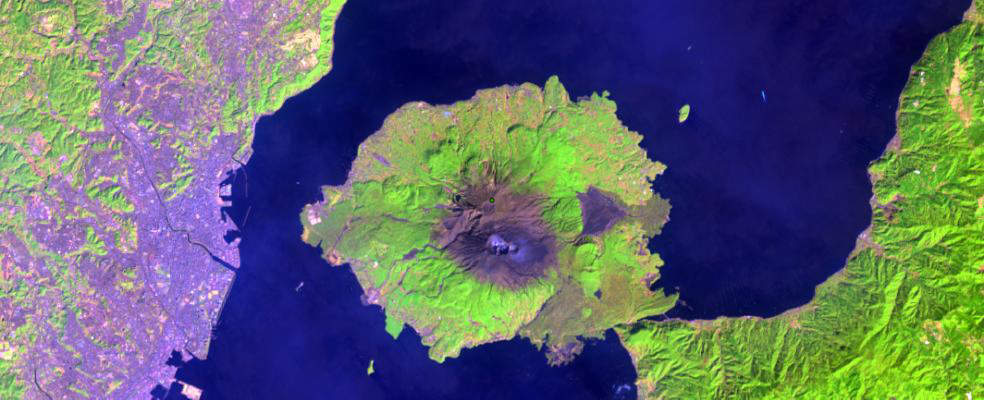

In [21]:
map3

In [22]:
visit_features_on_map_widget(map3, fclist_r, zoom_level=6, timesleep=15)

extent:  [[112.40000000032384, -16.79999999991971], [128.20000000002094, -11.600000000103169]]
center:  [-34.64446000027924, -71.90416999988342]
center:  [46.27979000024183, 8.92218000030607]
center:  [-28.016250000056097, 23.64451000039107]
center:  [-38.249999999651955, -72.68330000022691]
center:  [10.828819999803141, -73.69334000039905]
center:  [-37.49967000013992, 147.8008299997917]
center:  [43.109719999733436, -4.853759999705724]
center:  [-38.00419000032389, -72.42126999998042]
center:  [-33.848719999867875, 121.86774999980268]
center:  [-28.135050000179383, 23.058830000101864]
center:  [42.18572000017736, 9.048909999693112]
center:  [-38.40886000007409, -72.78212999955228]
center:  [-32.98674999971305, 20.018949999856233]
center:  [56.056000000125586, 160.64199999988276]
center:  [-39.42000000016619, -71.93000000035782]
center:  [54.04899999991689, 159.44300000043197]
center:  [-21.244000000015486, 55.70799999989505]
center:  [10.199999999845884, -84.23300000009152]
center:  

Or, if you know the exact location (center or extents) of the event, set the map to display the area manually.

In [23]:
# Wildfire, Spain
map3.zoom = 13
map3.center = [43.10972, -4.85376]

In [24]:
# Sabancaya Volcano, Peru
map3.zoom = 12
map3.center = [-15.779999999986844,  -71.85000000002958]

In [25]:
# Or Aira Volcano, Japan
map3.zoom = 12.5
map3.center = [31.592999999761126, 130.6570000002089]


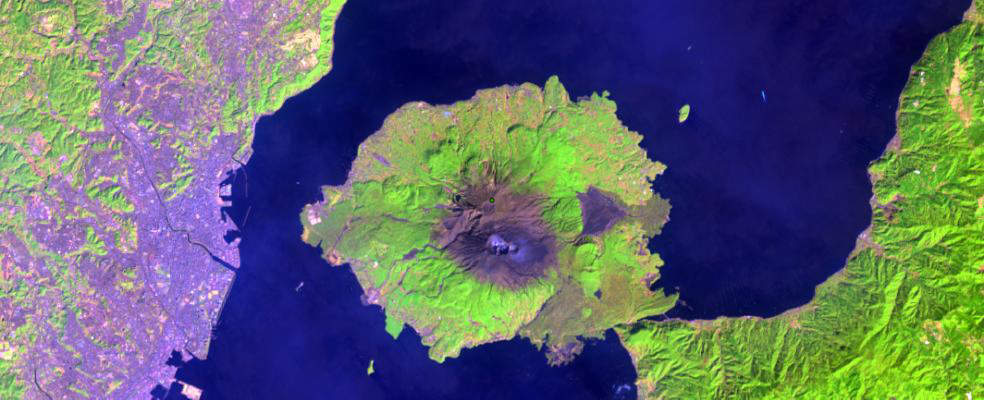

In [33]:
filename = Path('output/screenshots/volcano.png')

map3.take_screenshot(file_path = str(filename))

In [34]:
filename = Path('output/html/' + "Natural Disasters (" + wm_token + ") Collection" + '.html')

map3.export_to_html(path_to_file = filename)

True

In [35]:
wm_item = exact_search(portal_gis, "Natural Disasters (" + wm_token + ") Collection", '*', 'Web Map')
wm_item

<Item title:"Natural Disasters (Tropical Cyclone, Wildfires, Volcano) Collection" type:Web Map owner:arcgis_python>

In [41]:
from arcgis.mapping import WebMap
webmap_obj = WebMap(wm_item)

counter_c, counter_v, counter_i, counter_w = (0,)*4

for lyr in webmap_obj.layers:
    if 'Cyclone' in lyr.title:
        print("({}) {}".format(counter_c, lyr.title))
        counter_c += 1
    elif 'Volcano' in lyr.title:
        print("({}) {}".format(counter_v, lyr.title))
        counter_v += 1
    elif 'Iceburg' in lyr.title:
        print("({}) {}".format(counter_i, lyr.title))
        counter_i == 1
    elif 'Wildfire' in lyr.title:
        print("({}) {}".format(counter_w, lyr.title))
        counter_w += 1
    else:
        pass
print("Reported incidents - Cyclone {}, Volcano {}, Iceburg {}, and Wildfire {} \
       ".format(counter_c, counter_v, counter_i, counter_w))

(0) Fuego Volcano, Guatemala
(1) Dukono Volcano, Indonesia
(2) Sheveluch Volcano, Russia
(3) Sabancaya Volcano, Peru
(4) Ebeko Volcano, Russia
(5) Aira Volcano, Japan
(6) Pacaya Volcano, Guatemala
(7) Ibu Volcano, Indonesia
(8) Santa Maria Volcano, Guatemala
(9) Krakatau Volcano, Indonesia
(10) Nevados de Chillan Volcano, Chile
(11) Turrialba Volcano, Costa Rica
(12) Etna Volcano, Italy
(13) Manam Volcano, Papua New Guinea
(14) Kadovar Volcano, Papua New Guinea
(15) Mayon Volcano, Philippines
(16) Suwanosejima Volcano, Japan
(17) Karangetang Volcano, Indonesia
(18) Bagana Volcano, Papua New Guinea
(19) Popocatepetl Volcano, Mexico
(20) Stromboli Volcano, Italy
(21) Planchón-Peteroa Volcano, Chile
(22) Reventador Volcano, Ecuador
(23) Agung Volcano, Indonesia
(24) San Cristobal Volcano
(25) Kerinci Volcano, Indonesia
(26) Bezymianny Volcano, Russia
(27) Barren Island Volcano, India
(28) Merapi Volcano, Indonesia
(29) Poas Volcano, Costa Rica
(30) Piton de la Fournaise Volcano, Réunion (

## Conclusion

This sample showcases an automated workflow to aggregate the recent ocurrences of natural disasters from NASA's EONET API, create according FeatureCollection based on the events and add the before- and post- disaster Landsat satellite images related to the event, and save all such layers in a web map item on target enterprise.Decision makers or Emergency Response crew can take advantage of this web map to perform disaster impact analysis or other operations.